In [20]:
import numpy as np
from pynq import allocate
from pynq import Overlay
from PIL import Image
import numpy as np
from matplotlib import cm
import math

In [21]:
ol = Overlay("mandelbrot14b5v.bit")
#ol?
dma = ol.axi_dma

In [22]:
imgwidth = 800
imgheight = 800

maxiterations = 100

StartX = -2.0
StopX = 0.47
StartY = -1.12
StopY = 1.12

inputregs = ol.axi_stream_template_0

inputregs.write(0x1C,imgwidth-1) #Output width
inputregs.write(0x20,imgheight-1) #Output height

inputregs.write(0x18,maxiterations) #Max iterations

inputregs.write(0x08,int(round(StartY*(2**28)))) #Start Y
inputregs.write(0x00,int(round(StopY*(2**28)))) #Stop Y

inputregs.write(0x0C,int(round(StartX*(2**28)))) #Start X
inputregs.write(0x04,int(round(StopX*(2**28)))) #Stop X

def start_image():
    inputregs.write(0x10,0x1)
    inputregs.write(0x10,0x0)

In [23]:
input_buffer = allocate(shape=(imgheight,imgwidth), dtype=np.uint32)

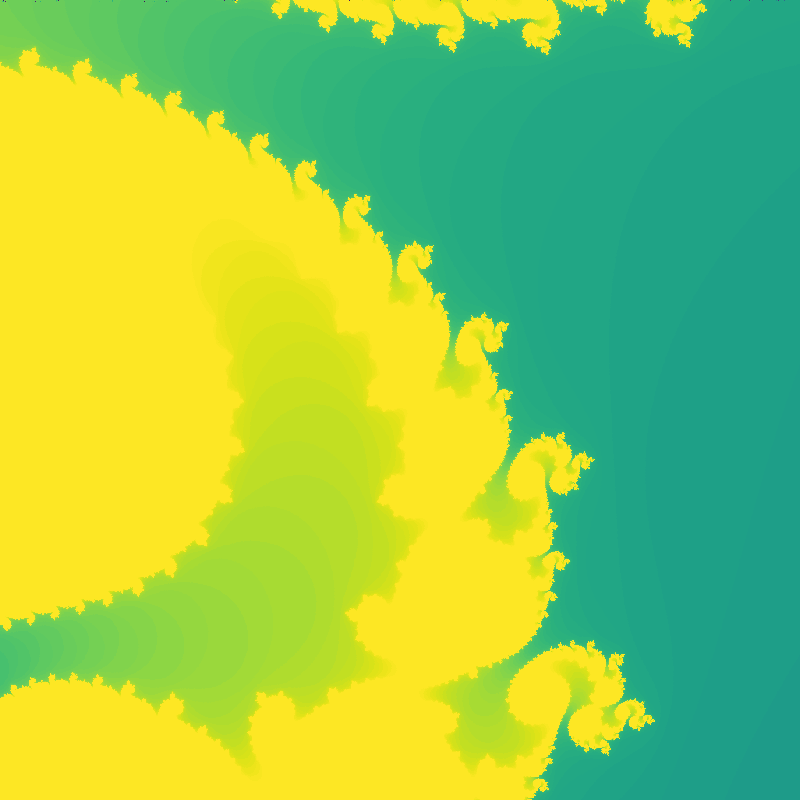

-0.7646868242622643 -0.7646863999194954 -0.09606642480007091 -0.09606603997100119
-0.7646868242622643 -0.7646863999194954 -0.09606642480007091 -0.09606603997100119


In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

def Update():
    global StopX
    global StartX
    global StopY
    global StartY
    clear_output()
    global maxiterations
    inputregs.write(0x14,imgwidth)

    start_image()

    for i in range(imgheight):
        dma.recvchannel.transfer(input_buffer[i])
        dma.recvchannel.wait()

    #display(input_buffer)
    #data = np.frombuffer(buffer,dtype=np.uint32).reshape((51,51))
    #np.savetxt("output.csv",data,delimiter=',', fmt='%d')

    data = np.frombuffer(input_buffer, dtype=np.uint32).reshape((imgwidth, imgheight))
    norm_data = data / data.max()
    colored_data = (cm.viridis(norm_data)[:, :, :3] * 255).astype(np.uint8)
    image = Image.fromarray(colored_data)
    display(box, image)
    print(StartX, StopX, StartY, StopY)
def DispButtonF(arg):
    Update()
def LeftButtonF(arg):
    global StopX
    global StartX
    
    width = StopX - StartX
    
    StopX = StopX - width * 0.25
    StartX = StartX - width * 0.25
    
    inputregs.write(0x0C,int(round(StartX*(2**28)))) #Start X
    inputregs.write(0x04,int(round(StopX*(2**28)))) #Stop X
    Update()
    print(width)
def RightButtonF(arg):
    global StopX
    global StartX
    
    width = StopX - StartX
    print(width)
    StopX = StopX + width * 0.25
    StartX = StartX + width * 0.25
    
    inputregs.write(0x0C,int(round(StartX*(2**28)))) #Start X
    inputregs.write(0x04,int(round(StopX*(2**28)))) #Stop X
    Update()
    print(width)
def UpButtonF(arg):
    global StopY
    global StartY
    
    height = StopY - StartY
    StopY = StopY - height * 0.1
    StartY = StartY - height * 0.1
    
    inputregs.write(0x08,int(round(StartY*(2**28)))) #Start Y
    inputregs.write(0x00,int(round(StopY*(2**28)))) #Stop Y
    Update()
    
def DownButtonF(arg):
    global StopY
    global StartY
    
    height = StopY - StartY
    StopY = StopY + height * 0.1
    StartY = StartY + height * 0.1
    
    inputregs.write(0x08,int(round(StartY*(2**28)))) #Start Y
    inputregs.write(0x00,int(round(StopY*(2**28)))) #Stop Y
    Update()
def ResetButtonF(arg):
    global StopX
    global StartX
    global StopY
    global StartY
    StartX = -2.0
    StopX = 0.47
    StartY = -1.12
    StopY = 1.12
    inputregs.write(0x08,int(round(StartY*(2**28)))) #Start Y
    inputregs.write(0x00,int(round(StopY*(2**28)))) #Stop Y
    inputregs.write(0x0C,int(round(StartX*(2**28)))) #Start X
    inputregs.write(0x04,int(round(StopX*(2**28)))) #Stop X
    Update()
    print(StartX, StopX, StartY, StopY)
    
def ZoomButtonF(arg):
    global StopX
    global StartX
    global StopY
    global StartY
    width = StopX - StartX
    height = StopY - StartY
    posX = (StopX+StartX)/2.0
    posY = (StopY+StartY)/2.0
    print(StartX, StopX, StartY, StopY)
    ratio = imgwidth/imgheight
    StartX = posX - width*0.2*ratio
    StopX = posX + width*0.2*ratio
    StartY = posY - height*0.2
    StopY = posY + height*0.2
    inputregs.write(0x08,int(round(StartY*(2**28)))) #Start Y
    inputregs.write(0x00,int(round(StopY*(2**28)))) #Stop Y
    inputregs.write(0x0C,int(round(StartX*(2**28)))) #Start X
    inputregs.write(0x04,int(round(StopX*(2**28)))) #Stop X
    Update()
def DebugButtonF(arg):
    print(StartX, StopX, StartY, StopY)
    
DispButton = widgets.Button(description = "Display")
LeftButton = widgets.Button(description = "Left")
RightButton = widgets.Button(description = "Right")
UpButton = widgets.Button(description = "Up")
DownButton = widgets.Button(description = "Down")
ResetButton = widgets.Button(description = "Reset")
ZoomButton = widgets.Button(description = "Zoom in")
DebugButton = widgets.Button(description = "Debug")

DispButton.on_click(DispButtonF)
LeftButton.on_click(LeftButtonF)
RightButton.on_click(RightButtonF)
UpButton.on_click(UpButtonF)
DownButton.on_click(DownButtonF)
ResetButton.on_click(ResetButtonF)
ZoomButton.on_click(ZoomButtonF)
DebugButton.on_click(DebugButtonF)


box = widgets.HBox([DispButton, LeftButton, RightButton, UpButton, DownButton, ResetButton, ZoomButton, DebugButton])
Update()
print(StartX, StopX, StartY, StopY)
